This code implements the fact based chunking method inspired by the research of Tony Chen et al (https://arxiv.org/abs/2312.06648) . It breaks down input text into atomic, factual, and self-contained propositions, then encodes them into a vector store for efficient retrieval in downstream tasks.

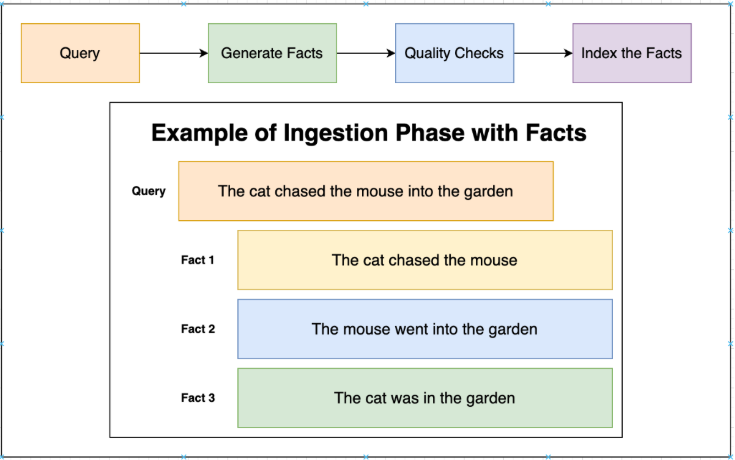

# **Objective**
The goal of the facts based chunking method is to break a document into short, proposition-based statements. This helps make information easier to find and retrieve more accurately. By using smaller, meaningful chunks instead of large blocks of text, the system can better answer specific questions - especially when dealing with detailed or complex content. This approach is compared with larger chunking methods to see which one gives better results for retrieving information.

## **Key Components**

1. **Document Chunking**: Splitting a document into manageable pieces for analysis.
2. **Facts Generation**: Using LLMs to break down document chunks into factual, self-contained propositions.
3. **Facts Quality Check**: Evaluating generated facts based on accuracy, clarity, completeness, and conciseness.
4. **Embedding and Vector Store**: Embedding both facts and larger chunks of the document into a vector store for efficient retrieval.
5. **Retrieval and Comparison**: Testing the retrieval system with different query sizes and comparing results from the fact-based model with the larger chunk-based model.


## 1. Install the required python libraries

In [5]:
!pip install -q pypdf tiktoken sentence-transformers faiss-cpu langchain
!pip install -q langchain-groq langchain-huggingface langchain-community

## 2. Import the required libraries

In [6]:
# Standard library imports
import os
import re
from typing import List

# Google Colab specific imports
from google.colab import userdata
from google.colab import files

# LangChain core imports
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate, \
FewShotChatMessagePromptTemplate

# LangChain community imports
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

# LangChain text processing
from langchain.text_splitter import RecursiveCharacterTextSplitter

# LLM providers
from langchain_groq import ChatGroq

# Pydantic for data validation
from pydantic import BaseModel, Field

# Set API keys
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')

## 3. Upload the document

In [7]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]
file_extension = os.path.splitext(filename)[1].lower()

Saving iobMost_Important_Terms_and_Conditions_Credit_Card.pdf to iobMost_Important_Terms_and_Conditions_Credit_Card.pdf


## 4. Read and Parse the content of the uploaded PDF

In [8]:
import os
import pypdf

def read_file_content(filename):
    """Read file content using pypdf for PDFs."""
    file_extension = os.path.splitext(filename)[1].lower()

    if file_extension == '.pdf':
        try:
            with open(filename, 'rb') as f:
                pdf_reader = pypdf.PdfReader(f)
                return "".join(page.extract_text() for page in pdf_reader.pages)
        except Exception as e:
            return f"PDF error: {str(e)}"

    # Text files with encoding detection
    for encoding in ['utf-8', 'latin-1', 'windows-1252']:
        try:
            with open(filename, 'r', encoding=encoding) as f:
                return f.read()
        except UnicodeDecodeError:
            continue

    # Binary fallback
    with open(filename, 'rb') as f:
        return f.read().decode('utf-8', errors='ignore')

# Execute
filename = list(uploaded.keys())[0]
file_content = read_file_content(filename)

## 5. Initialize the embedding model

In [9]:
embedding_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-base-en-v1.5",  # Better for financial text
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True}  # Essential for BGE models
)

<ipython-input-9-71e31e03b1ca>:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
import warnings

# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


## 6. Document Preparation and Chunking using TextSplitter

In [11]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500,     # Larger chunks for better financial context (256-512 range)
    chunk_overlap=150,  # More overlap to preserve financial terms/context
    separators=[
        "\n\n",     # Paragraph breaks
        "\n",       # Line breaks
        ". ",       # Sentence endings
        ") ",       # After numbered/lettered points (common in financial docs)
        ": ",       # After headings/labels
        " ",        # Word boundaries
        ""
    ]
)

docs_list = [Document(
    page_content=file_content,
    metadata={
        "Title": "IOB Credit Card MITC",
        "Source": f"PDF - {filename}",
        "Document_Type": "Financial_Terms"
    }
)]

print(f"✅ Loaded {len(docs_list)} document(s) with {len(file_content.split())} words.")

✅ Loaded 1 document(s) with 2956 words.


In [12]:
# Chunk documents
doc_splits = text_splitter.split_documents(docs_list)

# Add chunk IDs and enhanced metadata for better tracking
for i, doc in enumerate(doc_splits):
    doc.metadata.update({
        "chunk_id": i,
        "chunk_size": len(doc.page_content),
        "word_count": len(doc.page_content.split())
    })

# Index into FAISS with better embeddings
vectorstore = FAISS.from_documents(doc_splits, embedding_model)

print(f"✅ Indexed {len(doc_splits)} chunks using BGE-Base embeddings")
print(f"📊 Model: {embedding_model.model_name}")
print(f"📄 Average chunk size: \
{sum(len(doc.page_content) for doc in doc_splits) // len(doc_splits)} characters")

✅ Indexed 14 chunks using BGE-Base embeddings
📊 Model: BAAI/bge-base-en-v1.5
📄 Average chunk size: 1787 characters


## 7. Structured Fact Extraction with LLM Processing

In [13]:
for i, doc in enumerate(doc_splits): # Add sequential chunk identifiers for tracking
    doc.metadata['chunk_id'] = i+1

# Define the output structure
class GenerateFacts(BaseModel):
    """List of all the facts in a given document"""
    facts: List[str] = Field(
        description="List of facts (factual, self-contained, and concise information)"
    )

# Initialize Groq LLM
llm = ChatGroq(
    model_name="gemma2-9b-it",
    groq_api_key=os.environ["GROQ_API_KEY"],
    temperature=0
)

# Enable structured output
structured_llm = llm.with_structured_output(GenerateFacts)

## 8. Few-Shot Learning Setup for Fact Extraction

In [14]:
# few-shot examples
facts_examples = [
    {
        "document": "The Great Wall of China stretches over 13,000 miles and \
        was primarily built to protect Chinese states from invasions.",
        "facts": [
            "The Great Wall of China stretches over 13,000 miles.",
            "The Great Wall was built to protect Chinese states.",
            "The Great Wall of China was intended to defend against invasions."
        ]
    },
    {
        "document": "Photosynthesis is the process by which green plants use \
        sunlight to produce energy from carbon dioxide and water.",
        "facts": [
            "Photosynthesis occurs in green plants.",
            "Photosynthesis uses sunlight, carbon dioxide, and water.",
            "Photosynthesis produces energy for the plant.",
            "Photosynthesis is a natural process in plants."
        ]
    }
]
example_facts_prompt = ChatPromptTemplate.from_messages([
    ("human", "{document}"),
    ("ai", "{facts}")
])
# Few-shot prompt setup
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_facts_prompt,
    examples=facts_examples,
)

## 9. System Prompt and Chain Configuration

In [15]:
# System-level prompt instructions
system = """
Please break down the following text into simple, self-contained facts. \
Ensure that each facts meets the following criteria:

1. Express a Single Fact: Each facts should state one specific fact or claim.

2. Be Understandable Without Context: The facts should be self-contained, \
meaning it can be understood without needing additional context.

3. Use Full Names, Not Pronouns: Avoid pronouns or ambiguous references; \
use full entity names.

4. Include Relevant Dates/Qualifiers: If applicable, include necessary dates, \
times, and qualifiers to make the fact precise.

5. Contain One Subject-Predicate Relationship: Focus on a single subject and \
its corresponding action or attribute, without conjunctions or multiple clauses.

"""

# Final prompt chain
prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    few_shot_prompt,
    ("human", "{document}")
])

facts_generator = prompt | structured_llm


## 10. Document Processing and Fact Extraction Execution

In [16]:
facts = []  # Store all the facts from the document

for i, chunk in enumerate(doc_splits):
    print(f"🔄 Processing chunk {i+1}/{len(doc_splits)}")

    response = facts_generator.invoke({"document": chunk.page_content})

    for fact in response.facts:
        # Reuse metadata from original chunk and add a chunk ID
        fact_metadata = dict(chunk.metadata)
        fact_metadata["chunk_id"] = i + 1

        facts.append(
            Document(page_content=fact, metadata=fact_metadata)
        )


🔄 Processing chunk 1/14
🔄 Processing chunk 2/14
🔄 Processing chunk 3/14
🔄 Processing chunk 4/14
🔄 Processing chunk 5/14
🔄 Processing chunk 6/14
🔄 Processing chunk 7/14
🔄 Processing chunk 8/14
🔄 Processing chunk 9/14
🔄 Processing chunk 10/14
🔄 Processing chunk 11/14
🔄 Processing chunk 12/14
🔄 Processing chunk 13/14
🔄 Processing chunk 14/14


## 11. Fact Quality Evaluation Framework

In [17]:
# 1. Define the structured output data model
class GradeFacts(BaseModel):
    """Grade a given fact on accuracy, clarity, completeness, and conciseness"""
    accuracy: int = Field(..., description="1-10 rating for how well the fact reflects the original text.")
    clarity: int = Field(..., description="1-10 rating for how easy it is to understand.")
    completeness: int = Field(..., description="1-10 rating for whether it includes key details.")
    conciseness: int = Field(..., description="1-10 rating for brevity without losing info.")

structured_llm = llm.with_structured_output(GradeFacts)


In [18]:
# 2. Prompt template
evaluation_prompt_template = """
Please evaluate the following fact based on these criteria:
- **Accuracy**: Does it reflect the original fact?
- **Clarity**: Can it be understood easily?
- **Completeness**: Does it have key details?
- **Conciseness**: Is it brief but informative?

Examples:
Original Text: In 1969, Neil Armstrong became the first person to walk on the \
Moon during the Apollo 11 mission.

Proposition: Neil Armstrong was an astronaut.
Evaluation: accuracy: 10, clarity: 10, completeness: 10, conciseness: 10

Proposition: Neil Armstrong walked on the Moon in 1969.
Evaluation: accuracy: 10, clarity: 10, completeness: 10, conciseness: 10

Now evaluate the following:

Original Text: {original_text}
Fact: {fact}
"""

prompt = ChatPromptTemplate.from_template(evaluation_prompt_template)
proposition_evaluator = prompt | structured_llm

## 11. Enhanced Fact Evaluation with Comprehensive Examples

In [19]:
evaluation_prompt_template = """
Please evaluate the following proposition based on these criteria:
- **Accuracy**: Does it reflect the original fact?
- **Clarity**: Can it be understood easily?
- **Completeness**: Does it have key details?
- **Conciseness**: Is it brief but informative?

Rate each from 1 to 10.

---

Example 1:
Original Text: The Great Wall of China was built over centuries to protect \
Chinese states from invasions and spans more than 13,000 miles.

Fact: The Great Wall of China was built for defense.
Evaluation: accuracy: 10, clarity: 10, completeness: 8, conciseness: 10

Fact: The Great Wall is 13,000 miles long and built to protect Chinese states.
Evaluation: accuracy: 10, clarity: 10, completeness: 10, conciseness: 10

Fact: The Great Wall of China was built in one year.
Evaluation: accuracy: 1, clarity: 9, completeness: 3, conciseness: 10

---

Example 2:
Original Text: Marie Curie was the first woman to win a Nobel Prize and \
remains the only person to win Nobel Prizes in two different scientific \
fields — Physics and Chemistry.

Fact: Marie Curie won two Nobel Prizes in science.
Evaluation: accuracy: 10, clarity: 10, completeness: 9, conciseness: 10

Fact: Marie Curie won the Nobel Prize for Literature.
Evaluation: accuracy: 1, clarity: 10, completeness: 2, conciseness: 10

Fact: Curie was the only person to win Nobel Prizes in Physics and Chemistry.
Evaluation: accuracy: 10, clarity: 10, completeness: 10, conciseness: 10

---

Example 3:
Original Text: The iPhone was first released by Apple in 2007 and \
revolutionized the smartphone industry with its touchscreen interface and app \
ecosystem.

Fact: Apple released the first iPhone in 2007.
Evaluation: accuracy: 10, clarity: 10, completeness: 10, conciseness: 10

Fact: The iPhone made smartphones popular.
Evaluation: accuracy: 9, clarity: 10, completeness: 7, conciseness: 10

Fact: iPhones were invented in the 1990s.
Evaluation: accuracy: 2, clarity: 10, completeness: 2, conciseness: 10

---

Now evaluate the following:

Original Text: {original_text}
Fact: {Fact}
"""

## 12. Fact Evaluation Pipeline and Quality Control

In [20]:
prompt = ChatPromptTemplate.from_template(evaluation_prompt_template)
fact_evaluator = prompt | structured_llm

# Define evaluation categories and thresholds
evaluation_categories = ["accuracy", "clarity", "completeness", "conciseness"]
thresholds = {category: 7 for category in evaluation_categories}

# Function to evaluate a fact against the original document text
def evaluate_fact(fact, original_text):
    response = fact_evaluator.invoke({
        "Fact": fact,
        "original_text": original_text
    })

    # Extract evaluation scores from the response
    scores = {
        "accuracy": response.accuracy,
        "clarity": response.clarity,
        "completeness": response.completeness,
        "conciseness": response.conciseness
    }
    return scores

# Function to check if the fact passes all quality thresholds
def passes_quality_check(scores):
    return all(score >= thresholds[category] for category, score in scores.items())


## 13. Batch Fact Evaluation and Quality Filtering

In [21]:
# Evaluate all generated facts
evaluated_facts = []

for idx, fact in enumerate(facts):
    chunk_id = fact.metadata.get("chunk_id", 1)
    original_text = doc_splits[chunk_id - 1].page_content

    scores = evaluate_fact(fact.page_content, original_text)

    if passes_quality_check(scores):
        evaluated_facts.append(fact)
    else:
        print(f"\n{idx+1}) Fact failed quality check")
        print(f"Fact: {fact.page_content}")
        print(f"Scores: {scores}")


10) Fact failed quality check
Fact: VISA GOLD has no annual fee.
Scores: {'accuracy': 1, 'clarity': 10, 'completeness': 2, 'conciseness': 10}

54) Fact failed quality check
Fact: No late payment fee or interest was applicable.
Scores: {'accuracy': 1, 'clarity': 8, 'completeness': 2, 'conciseness': 8}


## 14. High-Quality Facts Vector Database and Retrieval

In [22]:
vectorstore_facts = FAISS.from_documents(evaluated_facts, embedding_model)
retriever_facts = vectorstore_facts.as_retriever(
                search_type="similarity",
                search_kwargs={'k': 4}, # number of documents to retrieve
            )
query = "what is the late charge for a credit card ?"
res_facts = retriever_facts.invoke(query)
for i, r in enumerate(res_facts):
    print(f"{i+1}) Content: {r.page_content} --- Chunk_id: {r.metadata['chunk_id']}")

1) Content: A Late Fee of Rs.100/- is charged after 3 days from the due date if the card member fails to pay at least the minimum dues. --- Chunk_id: 3
2) Content: A late payment fee is charged if the minimum dues are not paid. --- Chunk_id: 2
3) Content: A late payment fee of Rs. 100/- was applicable. --- Chunk_id: 5
4) Content: If the total due amount is not paid by the due date, interest is charged from the date of purchase until the next due date. --- Chunk_id: 4


## 15. Retrieval with verbosed content from documents

In [23]:
retriever_with_more_content = vectorstore.as_retriever(
                search_type="similarity",
                search_kwargs={'k': 4},
            )

response = retriever_with_more_content.invoke(query)

for i, r in enumerate(response):
    content = r.page_content

    # Split content into lines and process each line
    lines = content.split('\n')
    formatted_lines = []

    for line in lines:
        line = line.strip()
        if line:
            if re.match(r'^[a-z]\)', line):
                formatted_lines.append(' ' + line)
            else:
                formatted_lines.append(line)

    formatted_content = '\n'.join(formatted_lines)
    print(f"{i+1}) Content from Chunk ID {r.metadata['chunk_id']}:\n{formatted_content}")

1) Content from Chunk ID 4:
purchase on 20/09/2021, the transaction would have been accounted in the
bill generated on 20/09/2021 where the due date of payme nt would have
been 10/10/2021. In this case,  Interest free credit period of 20 days would
have been available. (Sep – 10 days, Oct – 10 days)
Case-I (Paid within Grace Period) – Customer pays the dues by
cash/NEFT/online on 12/11/2021. Since this is within  the grace period, this
Page 3 of 7
will be deemed to have been paid in time and accordingly late payment fee
and interest for non-payment/delayed payment shall not be applicable.
Case-II (Not Paid within Grace Period) - Customer pays minimum dues of
Rs. 1100/- by cash/NEFT/online on 13/11/2021. Since total dues is not paid
within the grace period , l ate payment fee and interest for non -
payment/delayed payment shall be applicable. Late payment fee for 1 month
– Rs.100/-, Applicable Interest - From 21/09/2021 for entire purchase of
Rs.11,000/-  till 12.11.2021 and from 13-11-